<a href="https://colab.research.google.com/github/goyal786/Parameter-Optimization-of-SVM/blob/main/Parameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas scikit-learn matplotlib optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt



In [7]:
# Load Dataset (Wine Quality)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Convert target into classification labels
data['quality'] = pd.cut(data['quality'], bins=[0, 5, 6, 10], labels=[0, 1, 2])  # simple 3-class mapping
X = data.drop('quality', axis=1)
y = data['quality'].astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Store results
results = []
convergence = []

[I 2025-05-20 20:00:18,574] A new study created in memory with name: no-name-c0c2bac0-4465-4cda-ace4-8068572f5d99
[I 2025-05-20 20:00:19,134] Trial 0 finished with value: 0.55625 and parameters: {'kernel': 'poly', 'nu': 0.16714330534248162, 'C': 3.3763393348240123}. Best is trial 0 with value: 0.55625.
[I 2025-05-20 20:00:20,042] Trial 1 finished with value: 0.5791666666666667 and parameters: {'kernel': 'poly', 'nu': 0.202185166748588, 'C': 6.774966314124412}. Best is trial 1 with value: 0.5791666666666667.
[I 2025-05-20 20:00:20,156] Trial 2 finished with value: 0.6666666666666666 and parameters: {'kernel': 'rbf', 'nu': 0.6789014702857096, 'C': 0.5520242344296805}. Best is trial 2 with value: 0.6666666666666666.
[I 2025-05-20 20:00:20,245] Trial 3 finished with value: 0.41041666666666665 and parameters: {'kernel': 'sigmoid', 'nu': 0.3920041398225428, 'C': 0.25611825246219033}. Best is trial 2 with value: 0.6666666666666666.
[I 2025-05-20 20:00:20,359] Trial 4 finished with value: 0.64

   Sample  Best Accuracy                                        Best Params
0      S1       0.687500  {'kernel': 'rbf', 'nu': 0.46605894947472665, '...
1      S1       0.679167  {'kernel': 'rbf', 'nu': 0.4417369675695591, 'C...
2      S2       0.666667  {'kernel': 'rbf', 'nu': 0.6004299245408986, 'C...
3      S3       0.654167  {'kernel': 'rbf', 'nu': 0.37126795372229004, '...
4      S4       0.712500  {'kernel': 'rbf', 'nu': 0.8374539584753482, 'C...
5      S5       0.666667  {'kernel': 'rbf', 'nu': 0.6645265073070745, 'C...
6      S6       0.677083  {'kernel': 'rbf', 'nu': 0.5157624841285805, 'C...
7      S7       0.702083  {'kernel': 'rbf', 'nu': 0.36977956073813106, '...
8      S8       0.672917  {'kernel': 'poly', 'nu': 0.5416065886121351, '...
9      S9       0.677083  {'kernel': 'rbf', 'nu': 0.7800105580892751, 'C...
10    S10       0.716667  {'kernel': 'rbf', 'nu': 0.33353058015644443, '...


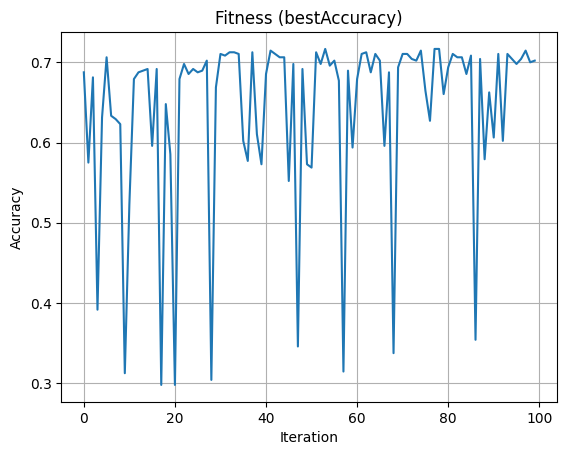

In [9]:
# Define optimization function
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    nu = trial.suggest_float('nu', 0.1, 0.9)
    # Change 'epsilon' to 'C' as required by NuSVR
    C = trial.suggest_float('C', 0.1, 10.0, log=True) # C is typically on a log scale and must be > 0

    # Pass the correct parameter name 'C' to the NuSVR constructor
    model = NuSVR(kernel=kernel, nu=nu, C=C)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_class = np.rint(preds).astype(int)
    preds_class = np.clip(preds_class, 0, 2)  # limit to class range
    acc = accuracy_score(y_test, preds_class)
    convergence.append(acc)
    return acc

# Run for 10 different samples
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=i)
    convergence = [] # Re-initialize convergence for each sample run
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    results.append({
        'Sample': f'S{i+1}',
        'Best Accuracy': study.best_value,
        'Best Params': study.best_params
    })

    # Check if the current sample has the best accuracy seen so far
    if not results or study.best_value >= max(r['Best Accuracy'] for r in results[:-1] if r['Best Accuracy'] is not None):
         # Save best convergence data only if it's the best so far
         best_convergence = convergence.copy()


# Save results to Table
df_results = pd.DataFrame(results)
print(df_results)

# Plot convergence of best SVM
plt.plot(best_convergence)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Fitness (bestAccuracy)")
plt.grid()
plt.show()

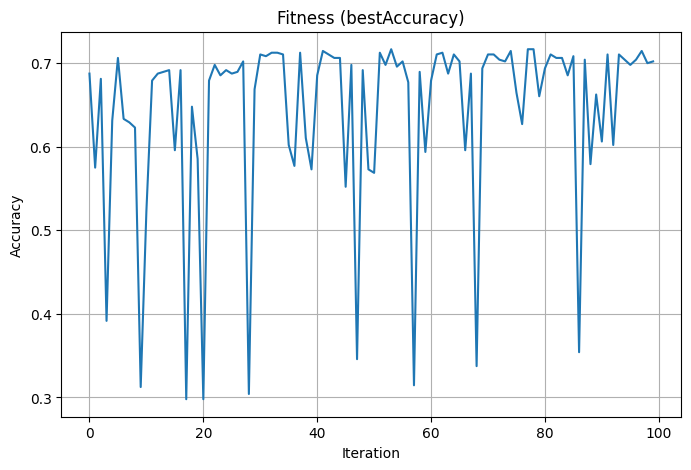

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Plot convergence of best SVM
plt.figure(figsize=(8, 5))
plt.plot(best_convergence)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Fitness (bestAccuracy)")
plt.grid(True)

# Save the figure to Google Colab environment
plt.savefig("/content/convergence_graph.png")
plt.show()

# Optional: Automatically download the file (if running in Google Colab)
from google.colab import files
files.download("/content/convergence_graph.png")
